<a href="https://colab.research.google.com/github/m-dergacheva/Yandex-Practicum_DA/blob/main/Yandex_%D0%9C%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BF%D1%80%D0%B8%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование поведение пользователей в мобильном приложении по продаже/обмену вещей

Представлены данные о сессиях пользователей, которые пользовались мобильным приложением по продаже вещей. В рамках данного исследования необходимо найти популярный сценарий, который приводит к целевому действию (просмотра контактов), а также оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.

**Описание данных:**  
Колонки в /datasets/mobile_dataset.csv :  
event.time — время совершения,  
user.id — идентификатор пользователя,  
event.name — действие пользователя.  
Виды действий:  
advert_open — открыл карточки объявления,  
photos_show — просмотрел фотографий в объявлении,  
tips_show — увидел рекомендованные объявления,  
tips_click — кликнул по рекомендованному объявлению,  
contacts_show и show_contacts — посмотрел номер телефона,  
contacts_call — позвонил по номеру из объявления,  
map — открыл карту объявлений,  
search_1 — search_7 — разные действия, связанные с поиском по сайту,  
favorites_add — добавил объявление в избранное.  

Колонки в /datasets/mobile_sources.csv :  
userId — идентификатор пользователя,  
source — источник, с которого пользователь установил приложение.

## Декомпозиция
Цель исследования - выявить, какие паттерны приводят к целевому действию (просмотр контактов)

1. Предоработка данных. Нахождение пропущенных значений, дубликатов (явных, неявных), проанализировать данные в части касающегося типов данных, наличия аномалий - при необходимости скорректировать данные.
2. Исследовательский анализ данных:  
    2.1. Когортный анализ. Retention Rate.    
    2.2. Оценка пользовательской активности. Расчеты MAU и DAU  
    2.3. Анализ и уточнение продолжительностей сесиий. Расчет среднего и медианного значения количества сессий на пользователя.   
    2.4. Выявление возможной последовательности действий пользователя в пределах сессии.Выявление сценариев пользователей.  
    2.5. Расчет популярности действий пользователей. Рассчитать относительную частоту событий в разрезе двух групп пользователей:  
    ○ группа пользователей, которые смотрели контакты contacts_show  
    ○ группа пользователей, которые не смотрели контакты contacts_show  
    2.6. Построение воронок. Расчет и сравнение конверсий.
3. Выводы
4. Гипотезы:  
    4.1. Одни пользователи совершают действия tips_show и tips_click , другие —
только tips_show . Проверьте гипотезу: конверсия в просмотры контактов
различается у этих двух групп.  
    4.2. Пользователи переходят на ресурс посредством разных источников. Гипотеза: конверсия в просмотры контактов различается у пользователей- yandex и пользователей google.   

In [126]:
#импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import scipy.stats as st
from tqdm import tqdm
import math as mth
import re

## Предобработка данных

In [127]:
# из библиотеки google.colab импортируем класс files
from google.colab import files
# создаем объект этого класса, применяем метод .upload()
uploaded = files.upload()

In [128]:
#открытие и запись файл
try:
    data_mobile=pd.read_csv('/content/mobile_dataset.csv') #сет с данными о сессиях
    data_source=pd.read_csv('/content/mobile_sourсes.csv') #сет с данными о ресурсах
except:
    data_mobile=pd.read_csv('C:/Users/Рита/Desktop/Yandex/FINAL/App/mobile_dataset.csv') #сет с данными о сессиях
    data_source=pd.read_csv('C:/Users/Рита/Desktop/Yandex/FINAL/App/mobile_sourсes.csv') #сет с данными о ресурсах

In [129]:
#отображение 5 первых строк
pd.set_option('display.float_format', '{:.2f}'.format)
display(data_mobile.head())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [130]:
#отображение 5 первых строк
pd.set_option('display.float_format', '{:.2f}'.format)
display(data_source.head())

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [131]:
#вывод информации о сете
data_mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [132]:
#вывод информации о сете
data_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [133]:
#переименование колонок
data_mobile.columns =['event_time', 'event_name', 'user_id']
data_source.columns = ['user_id', 'source']

In [134]:
#перевод данных с датой в тип datetime
data_mobile['event_time']=pd.to_datetime(data_mobile['event_time'], format='%Y-%m-%d %H:%M:%S')
data_mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [135]:
#объединение 2 сетов с данными
temp=data_mobile.merge(data_source,on='user_id',how='left')
temp.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


In [136]:
#вывод уникальных значений и их кол-во в столбце event_name
print(temp['event_name'].value_counts())

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64


В документации указано что search - это "разные действия по поиску". Т.к. не дано определение более точное, вероятно этими уточнениями можно пренебречь.

In [137]:
temp['event_name'] =temp['event_name'] .str.replace('^search_\d+', 'search', regex='True')
temp['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call',
       'show_contacts'], dtype=object)

In [138]:
def rename_col(row):
    if row=='contacts_show' or row=='show_contacts':
        return 'contacts_show'
    else:
        return row
temp['event_name']=temp['event_name'].apply(rename_col)
temp

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
...,...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
74194,2019-11-03 23:56:57.041825,search,20850c8f-4135-4059-b13b-198d3ac59902,google
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google


In [139]:
temp['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

In [140]:
#вывод даты из времени и приведение в комфортный вид
temp['event_date'] = temp['event_time'].dt.strftime("%Y-%m-%d")
temp['event_time'] = temp['event_time'].dt.strftime("%Y-%m-%d %H:%M:%S")
temp['event_time'] = pd.to_datetime(temp['event_time'], format='%Y-%m-%d')
temp['event_date'] = pd.to_datetime(temp['event_date'], format='%Y-%m-%d %H:%M:%S')
temp

,event_time,event_name,user_id,source,event_date
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
...,...,...,...,...,...
74192,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03
74194,2019-11-03 23:56:57,search,20850c8f-4135-4059-b13b-198d3ac59902,google,2019-11-03
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03


In [141]:
# выделяем год, номер месяца и номер недели из времени начала сессии
temp['event_year'] = temp['event_time'].dt.year
temp['event_month'] = temp['event_time'].dt.month
temp['event_week'] = temp['event_time'].dt.isocalendar().week
temp.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41


In [142]:
#дублирование сета для сравнения до/после преобразований
copy_temp=temp.copy()

In [143]:
#поиск дубликатов
temp[temp.duplicated(subset=['event_time','user_id','event_name'], keep=False)]

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week
395,2019-10-07 11:00:20,tips_show,fb667205-a708-4693-832d-363a30022cfc,yandex,2019-10-07,2019,10,41
396,2019-10-07 11:00:20,tips_show,fb667205-a708-4693-832d-363a30022cfc,yandex,2019-10-07,2019,10,41
421,2019-10-07 11:10:39,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex,2019-10-07,2019,10,41
422,2019-10-07 11:10:39,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex,2019-10-07,2019,10,41
423,2019-10-07 11:10:40,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex,2019-10-07,2019,10,41
...,...,...,...,...,...,...,...,...
73760,2019-11-03 21:27:06,photos_show,da4b7af3-c603-457a-8506-71d90077417b,google,2019-11-03,2019,11,44
73793,2019-11-03 21:36:08,search,78756227-406d-4cd5-8778-966d50b4f46d,yandex,2019-11-03,2019,11,44
73794,2019-11-03 21:36:08,search,78756227-406d-4cd5-8778-966d50b4f46d,yandex,2019-11-03,2019,11,44
73838,2019-11-03 21:45:22,photos_show,1af9ffcd-2c77-4de0-9d35-3ff30604c9bd,google,2019-11-03,2019,11,44


In [144]:
#удаление дубликатов
temp.drop_duplicates(subset=['event_time','user_id','event_name'], keep='first', inplace=True)
temp.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41


In [145]:
temp.isna().sum()

event_time     0
event_name     0
user_id        0
source         0
event_date     0
event_year     0
event_month    0
event_week     0
dtype: int64

In [146]:
# сравнение объемов данных до и после преобразования
a, b = len(copy_temp), len(temp)
print(len(copy_temp), len(temp), round((a-b)/a*100, 2))

74197 72973 1.65


### Вывод:  
Представлены данные о времени и действиях пользвотелей с указанием id пользователя, а также данные об источниках данных (откуда перешел пользователь) с указанием id. Данные были преобразованы, в части касающихся данных о времени (переведены в соответствующие типы данные о дате, времени, выделены месяцы и недели). Были объеденены данные по типу действия search (было предположено, что если в данных/описании данных не указана конкретика о типе поиска, то такими данными можно пренебречь и такие данные объединить). Были выявлены дубликаты по id, времени и типу действия). Такие данные предлагается удалить (потеря данных от первичного объема составила менее 2%).

## Исследовательский анализ данных

### Когортный анализ. Retention Rate.

In [147]:
#вывод 5 строк сета
temp.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41


In [148]:
#считаем начало сессий
first_date = temp.groupby(['user_id'])['event_date'].first()
first_date.name = 'first_date'
user_activity = temp.join(first_date,on='user_id')
user_activity.tail()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,first_date
74192,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16
74194,2019-11-03 23:56:57,search,20850c8f-4135-4059-b13b-198d3ac59902,google,2019-11-03,2019,11,44,2019-10-27
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16
74196,2019-11-03 23:58:12,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16


In [149]:
user_activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72973 entries, 0 to 74196
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   event_time   72973 non-null  datetime64[ns]
 1   event_name   72973 non-null  object        
 2   user_id      72973 non-null  object        
 3   source       72973 non-null  object        
 4   event_date   72973 non-null  datetime64[ns]
 5   event_year   72973 non-null  int64         
 6   event_month  72973 non-null  int64         
 7   event_week   72973 non-null  UInt32        
 8   first_date   72973 non-null  datetime64[ns]
dtypes: UInt32(1), datetime64[ns](3), int64(2), object(3)
memory usage: 5.4+ MB


Для вычисления Retention Rate предлагается расчитывать lifetime в неделях.  

In [150]:
#найдем даты начала недели event_date и начала недели, первой даты сессии

''' для этого из даты события и даты первой сессии вычтем порядковый номер дня недели, переведенный в тип timedelta в днях.
Без перевода в соответствующий тип, программа выдаст ошибку, т.к. из даты нельзя вычитать int'''

user_activity['activity_week'] = user_activity['event_date'] - pd.to_timedelta(user_activity['event_date'].dt.weekday, unit='day')
user_activity['first_activity_week'] = user_activity['first_date'] - pd.to_timedelta(user_activity['first_date'].dt.weekday, unit='day')
user_activity.tail()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,first_date,activity_week,first_activity_week
74192,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16,2019-10-28,2019-10-14
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16,2019-10-28,2019-10-14
74194,2019-11-03 23:56:57,search,20850c8f-4135-4059-b13b-198d3ac59902,google,2019-11-03,2019,11,44,2019-10-27,2019-10-28,2019-10-21
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16,2019-10-28,2019-10-14
74196,2019-11-03 23:58:12,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16,2019-10-28,2019-10-14


In [151]:
# вычисляем лайфтайм для каждой сессии в неделях

#находим лайфттайм
user_activity['lifetime'] = (user_activity['activity_week'] - user_activity['first_activity_week'])
#данные получились в днях, поэтому переводим данные в недели
user_activity['lifetime']=user_activity['lifetime']//pd.to_timedelta(7,unit='day')
user_activity.tail(5)

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,first_date,activity_week,first_activity_week,lifetime
74192,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16,2019-10-28,2019-10-14,2
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16,2019-10-28,2019-10-14,2
74194,2019-11-03 23:56:57,search,20850c8f-4135-4059-b13b-198d3ac59902,google,2019-11-03,2019,11,44,2019-10-27,2019-10-28,2019-10-21,1
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16,2019-10-28,2019-10-14,2
74196,2019-11-03 23:58:12,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03,2019,11,44,2019-10-16,2019-10-28,2019-10-14,2


Участников всех когорт изначально объединяет какое-нибудь событие. В данном случае - это первое использование приложения. Так в анализ попадает только определённая категория людей — впервые посетившие приложение.  
Чтобы рассчитать Retention Rate, количество активных пользователей на текущий день делят на количество активных пользователей на первый день.

In [152]:
# строим таблицу удержания
#user_activity['first_activity_week']=pd.to_datetime(user_activity['first_activity_week'], format='%Y-%m-%d')
user_activity['first_activity_week']=user_activity['first_activity_week'].astype('str')
result_grouped = user_activity.pivot_table(index=['first_activity_week'], columns='lifetime', values='user_id', aggfunc='nunique')
result_grouped

lifetime,0,1,2,3
first_activity_week,,,,
2019-10-07,1130.00,272.00,170.00,119.00
2019-10-14,1166.00,282.00,155.00,NaN
2019-10-21,1094.00,239.00,NaN,NaN
2019-10-28,903.00,NaN,NaN,NaN


In [153]:
# вычисляем размеры когорт
cohort_sizes = (user_activity.groupby('first_activity_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'}))
cohort_sizes

,cohort_size
first_activity_week,
2019-10-07,1130
2019-10-14,1166
2019-10-21,1094
2019-10-28,903


In [154]:
# объединяем размеры когорт и таблицу удержания
result_grouped = cohort_sizes.merge(result_grouped, on='first_activity_week', how='left').fillna(0)
result_grouped

,cohort_size,0,1,2,3
first_activity_week,,,,,
2019-10-07,1130,1130.00,272.00,170.00,119.00
2019-10-14,1166,1166.00,282.00,155.00,0.00
2019-10-21,1094,1094.00,239.00,0.00,0.00
2019-10-28,903,903.00,0.00,0.00,0.00


In [155]:
# делим данные таблицы удержания на размеры когорт
result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0).drop(columns=['cohort_size'])
#result_grouped=result_grouped.reset_index(drop=False)
#result_grouped['first_activity_week']=result_grouped['first_activity_week'].astype('str')
result_grouped

,0,1,2,3
first_activity_week,,,,
2019-10-07,1.00,0.24,0.15,0.11
2019-10-14,1.00,0.24,0.13,0.00
2019-10-21,1.00,0.22,0.00,0.00
2019-10-28,1.00,0.00,0.00,0.00


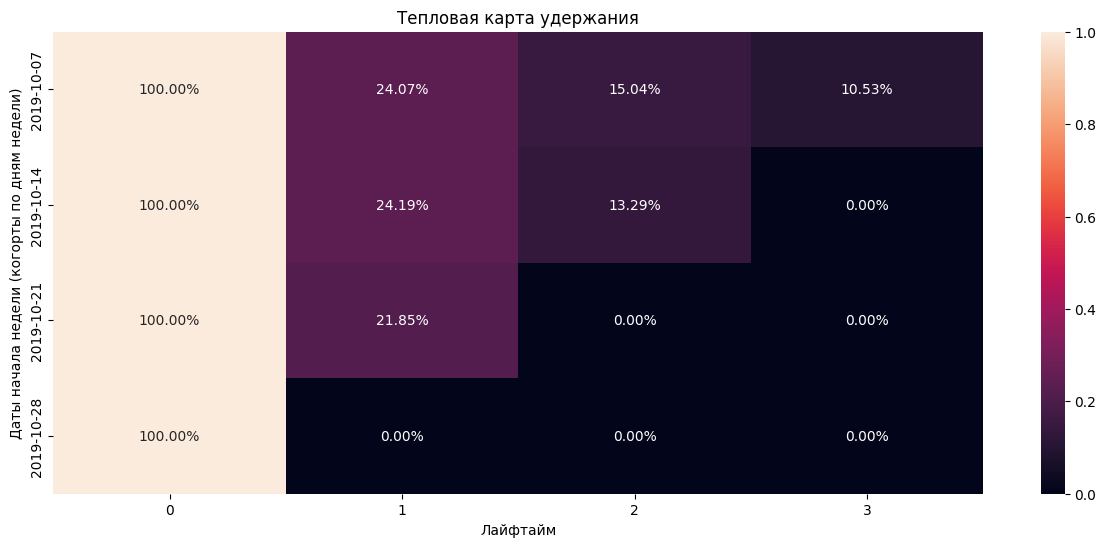

In [156]:
# строим хитмэп без нулевого лайфтайма
plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    result_grouped,
    annot=True,# включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.ylabel('Даты начала недели (когорты по дням недели)')
plt.xlabel('Лайфтайм')
plt.title('Тепловая карта удержания')  # название графика
plt.show()

In [157]:
#вывод кривой удержания
fig = px.line(result_grouped.T)
fig.update_layout(title='Кривые удержания по дням привлечения',
                 height=500, width=800,
                 xaxis_title="Коэф. удержания",
                yaxis_title="Лайфтайм")
fig.show()

#### Вывод:  
Лучшее удержание во второй неделе показали пользователи, привлеченные во вторую неделю(с 14-10-2019). На третью неделю, лучше всего показатель у пользователей, привлеченные в первую неделю (7-10-2019). При этом с течением времени удержание стабильно падает у пользователей, привлеченные в первую неделю, и резко этот показатель снижается для пользователей привлеченные в другие недели (при этом анализировать пользователей привлеченные в четвертую неделю затруднительно, так как для полноценного анализа нужны данные за более продолжительный период).
Следовательно, можно предположить, что пользователей привлеченных в первый период во-первых больше, и во-вторых, такие пользователи показали большую лояльность.  
Самый высокий коэффициент удержания — у когорт 1 недели. Детальнее сравнить показатели когорт график не позволяет — линии сливаются.

### Оценка пользовательской активности. Расчеты MAU и DAU

In [158]:
#вывод первых строк
temp.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41


In [159]:
#расчеты метрик
dau_total = (temp.groupby('event_date').agg({'user_id': 'nunique'}).mean())
wau_total = (temp.groupby(['event_year', 'event_week']).agg({'user_id': 'nunique'}).mean())

print(f'Cреднее количество уникальных пользователей в день: {dau_total} .Среднее количество уникальных пользователей в неделю: {wau_total}')

sticky_factor=(dau_total / wau_total * 100)

print(f'Sticky factor, отражающий регулярность использования сервиса или приложения и для недельной аудитории составляет: {sticky_factor}')

Cреднее количество уникальных пользователей в день: user_id   279.18
dtype: float64 .Среднее количество уникальных пользователей в неделю: user_id   1382.50
dtype: float64
Sticky factor, отражающий регулярность использования сервиса или приложения и для недельной аудитории составляет: user_id   20.19
dtype: float64


In [160]:
#отображение метрики по дням
test_dau=temp.pivot_table(index='event_date', values='user_id', aggfunc='nunique')

fig = px.line(test_dau)
fig.update_layout(title='Кривая параметра DAU',
                 height=500, width=800,
                 xaxis_title="Уникальные пользователи",
                yaxis_title="Дата")
fig.show()

In [161]:
#отображение метрики по неделям
test_wau=temp.pivot_table(index='event_week', values='user_id', aggfunc='nunique')

fig = px.line(test_wau)
fig.update_layout(title='Кривая параметра WAU',
                 height=500, width=800,
                 xaxis_title="Уникальные пользователи",
                yaxis_title="Дата")
fig.show()

#### Вывод:  
Показатель "липучести" Sticky factor составляет 20%, при этом, параметр DAU немного растет со временем, и параметр WAU также растет, но к концу исследуемого периода падает. Такая тенденция вкупе с низким показателем "липучести" пользователей вероятно свидетельствует о низком уровне лояльности пользователей.

### Анализ и уточнение продолжительностей сесиий. Расчет среднего и медианного значения количества сессий на пользователя.

In [162]:
#сортировка сета по id и времени
temp=temp.sort_values(['user_id', 'event_time'])
temp.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week
805,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41
806,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41
809,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41
820,2019-10-07 13:43:20,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41
830,2019-10-07 13:45:30,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41


Для того, чтобы предположить длительности сессий, предлагается изучить временные интервалы между первым и последним действием пользователя в рамках дня, а также временные интервалы между действиями в рамках дня. После изученных данных, предлагается предположить возможную длительность сессий и длительность времени бездействия, после которого считается сессия завершена.

In [163]:
#исследование продолжительности сессий в рамках дня
duration_ses=temp.pivot_table(index=["user_id","event_date"], values='event_time', aggfunc=['first','last']).reset_index(drop=False)
duration_ses.columns=['user_id','event_date','start','finish']
duration_ses['diff']=duration_ses['finish']-duration_ses['start']
duration_ses['diff']=duration_ses['diff'].apply(lambda x:x.total_seconds())
duration_ses['diff_min']=duration_ses['diff'].apply(lambda x:x/60)
duration_ses.head()

,user_id,event_date,start,finish,diff,diff_min
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45,2019-10-07 13:49:41,596.00,9.93
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55,2019-10-09 18:42:22,507.00,8.45
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30,2019-10-21 20:07:30,900.00,15.00
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14,2019-10-22 11:30:52,758.00,12.63
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33,2019-10-19 21:59:54,1521.00,25.35


In [164]:
#вывод графика
fig = px.box(duration_ses['diff_min'])
fig.update_yaxes(range=[0, 200])
fig.update_layout(title='Время активности пользователей в минутах',
                 height=500, width=700,
                 xaxis_title="Разница",
                yaxis_title="Секунды")
fig.show()

In [165]:
#перевод данных в тип datetime
duration_ses['event_date']=pd.to_datetime(duration_ses['event_date'])
duration_ses['session_month'] = duration_ses['event_date'].dt.month
duration_ses['session_week'] = duration_ses['event_date'].dt.isocalendar().week
duration_ses['weekday']=duration_ses['event_date'].dt.isocalendar().day

In [166]:
#функция для перевода номера дня в день недели
def rename_calend(raw):
    if raw == 1:
        return 'Понедельник'
    elif raw == 2:
        return 'Вторник'
    elif raw == 3:
        return 'Среда'
    elif raw == 4:
        return 'Четверг'
    elif raw == 5:
        return 'Пятница'
    elif raw == 6:
        return 'Суббота'
    elif raw == 7:
        return 'Воскресенье'
duration_ses['name_weekday'] = duration_ses['weekday'].apply(rename_calend)
duration_ses.head()

,user_id,event_date,start,finish,diff,diff_min,session_month,session_week,weekday,name_weekday
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45,2019-10-07 13:49:41,596.00,9.93,10,41,1,Понедельник
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55,2019-10-09 18:42:22,507.00,8.45,10,41,3,Среда
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30,2019-10-21 20:07:30,900.00,15.00,10,43,1,Понедельник
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14,2019-10-22 11:30:52,758.00,12.63,10,43,2,Вторник
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33,2019-10-19 21:59:54,1521.00,25.35,10,42,6,Суббота


In [167]:
#исследование продолжительности сессии в рамках недели
week_sessions_continues=duration_ses.pivot_table(index=['session_week','weekday','name_weekday'], values='diff', aggfunc=['sum','mean','median']).reset_index(drop=False).sort_values(by='weekday', ascending=True)
week_sessions_continues.columns=['session_week','weekday','name_weekday','sum','mean','median']
week_sessions_continues.loc[:,'sum':'median']=week_sessions_continues.loc[:,'sum':'median']/60
week_sessions_continues['sum']=week_sessions_continues['sum']/60
week_sessions_continues.head()

,session_week,weekday,name_weekday,sum,mean,median
0,41,1,Понедельник,162.48,47.79,13.05
21,44,1,Понедельник,456.49,78.70,11.13
14,43,1,Понедельник,430.54,79.24,8.89
7,42,1,Понедельник,384.58,77.43,15.17
1,41,2,Вторник,258.24,75.95,16.38


In [168]:
#вывод графика
fig = px.line(week_sessions_continues, x="name_weekday", y="sum", color='session_week')
fig.update_layout(title='Суммарная продолжительность сессий пользователя (в день)',
                 height=500, width=700,
                  xaxis_title="День недели",
                yaxis_title="Продолжительность сессий (мин.)")
fig.show()

Суммарная продолжительность сессиий по пользователям самой высокой была в период третьей недели, и самая низкая - в период первой. При этом на четвертой неделе, после подема в период третьей недели, продолжительность стала снижаться.  
В целом, больше всего времени суммарно пользователи проводили в приложении в период с понедельника по среду, и далее показатель снижался, при этом на выходные (суббота и воскресенье) продолжительность снова увеличивалась.

In [169]:
#вывод графика
fig = px.line(week_sessions_continues, x="name_weekday", y='mean', color='session_week')
fig.update_layout(title='Средняя продолжительность сессий пользователя (в день)',
                 height=500, width=700,
                  xaxis_title="День недели",
                yaxis_title="Продолжительность сессий (мин.)")
fig.show()

Средняя суммарная продолжительность сесиий  на четвертой неделе также в целом ниже чем неделей ранее. Аналогично предыдущему выводу, наибольший интерес к приложению пользователи испытывают к концу недели.

In [170]:
#среднее время между действиями пользователей в минутах
res=temp.groupby(["user_id","event_date"])['event_time'].diff()
a=res.mean()
b=res.median()
print(a, b)

0 days 00:09:57.709098164 0 days 00:01:07


In [171]:
#среднее и медианное значение между действиями пользователя в секундах
duration_diff=temp.pivot_table(index=["user_id","event_date"], values='event_time', aggfunc='diff').reset_index(drop=False)
duration_diff['event_time']=duration_diff['event_time'].apply(lambda x:x.total_seconds())
f=duration_diff['event_time'].mean()
g=duration_diff['event_time'].median()
print(f, g)

597.7090981644054 67.0


In [172]:
#вывод графика
fig = px.box(duration_diff['event_time'])
fig.update_yaxes(range=[0, 500])
fig.update_layout(title='Время между действиями пользователя в секундах',
                 height=500, width=700,
                 xaxis_title="Разница",
                yaxis_title="Секунды")
fig.show()

Медианное значение продолжительности сессии составяет около 12 минут, а среднее 1,5 часа.
Медианное значение времени между откликами пользователя составляет 1 минута, среднее - примерно 10 минут.
С учетом наличия выбросов в полученных данных, предлагается ориентироваться на среднее значение.
Таким образом, время бездействия предлагается выбрать больше 10 минут.

In [173]:
#определяем время бездействия и выделяем сессии
g = (temp.groupby('user_id')['event_time'].diff() > pd.Timedelta('10Min')).cumsum()
temp['session_id'] = temp.groupby(['user_id', g], sort=False).ngroup() + 1
display (temp.tail())

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
72584,2019-11-03 15:51:23,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,2019,11,44,12688
72589,2019-11-03 15:51:57,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,2019,11,44,12688
72684,2019-11-03 16:07:40,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,2019,11,44,12689
72688,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,2019,11,44,12689
72689,2019-11-03 16:08:25,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,2019,11,44,12689


In [174]:
#подсчет кол-ва сессий по всем пользователям в целом
count_sessions=temp.pivot_table(index='user_id', values='session_id', aggfunc='nunique').sort_values(by='session_id', ascending=False)
count_sessions['medians']=count_sessions['session_id'].median()
count_sessions['means']=count_sessions['session_id'].mean()
count_sessions

,session_id,medians,means
user_id,,,
21230dd9-2f7f-4b77-a436-43d4d10388e0,124,2.00,2.96
cb36854f-570a-41f4-baa8-36680b396370,101,2.00,2.96
be1449f6-ca45-4f94-93a7-ea4b079b8f0f,64,2.00,2.96
1580911b-65db-4f1a-be7e-1ca39becac30,63,2.00,2.96
e13f9f32-7ae3-4204-8d60-898db040bcfc,55,2.00,2.96
...,...,...,...
16bbdca6-bfd8-4618-9c71-f38597f5cb1f,1,2.00,2.96
16c6bd84-7832-4e63-a304-edf55b14256d,1,2.00,2.96
96392d6f-cf9c-495c-9912-1a7e5ffd26e4,1,2.00,2.96


In [175]:
#вывод графика
fig = px.box(count_sessions['session_id'])
fig.update_yaxes(range=[0, 30])
fig.update_layout(title='Количество сессий пользователей (за весь период)',
                 height=500, width=700,
                yaxis_title="Кол-во сессий")
fig.show()

In [176]:
#подсчет кол-ва сессий по всем пользователям по дням
count_sessions_day=temp.pivot_table(index=['event_date'], values='session_id', aggfunc='nunique').reset_index(drop=False).sort_values(by='session_id', ascending=False)
count_sessions_day['medians']=count_sessions_day['session_id'].median()
count_sessions_day['means']=count_sessions_day['session_id'].mean()
count_sessions_day.head()

,event_date,session_id,medians,means
16,2019-10-23,565,478.00,454.57
21,2019-10-28,563,478.00,454.57
22,2019-10-29,559,478.00,454.57
23,2019-10-30,558,478.00,454.57
14,2019-10-21,545,478.00,454.57


In [177]:
#вывод графика
fig = px.box(count_sessions_day['session_id'])
fig.update_yaxes(range=[0, 1000])
fig.update_layout(title='Количество сессий пользователей (в день)',
                 height=500, width=700,
                yaxis_title="Кол-во сессий")
fig.show()

In [178]:
#подсчет кол-ва сессий по пользователям в день
count_sessions_day_per_user=temp.pivot_table(index=['user_id','event_date'], values='session_id', aggfunc='nunique').reset_index(drop=False).sort_values(by='session_id', ascending=False)
count_sessions_day_per_user.columns=['user_id','event_date','count_sessions']
count_sessions_day_per_user.head()

,user_id,event_date,count_sessions
6563,d5e14ec3-7ae5-4598-ad36-f626b3ce24e3,2019-10-31,14
6210,cb36854f-570a-41f4-baa8-36680b396370,2019-10-28,12
4382,8ebe803e-8885-4e60-a43b-6ae98fe89e46,2019-10-15,12
1569,30fcdb5c-e6b3-409d-a8f3-a2b26e5e4f25,2019-10-07,12
4507,955bd7b0-8da8-49df-adee-546b59347634,2019-10-15,11


In [179]:
#вывод графика
fig = px.box(count_sessions_day_per_user['count_sessions'])
fig.update_yaxes(range=[0, 10])
fig.update_layout(title='Количество сессий пользователя (в день)',
                 height=500, width=700,
                yaxis_title="Кол-во сессий")
fig.show()

In [180]:
#преобразование типов datetime
count_sessions_day_per_user['event_date']=pd.to_datetime(count_sessions_day_per_user['event_date'])
count_sessions_day_per_user['session_month'] = count_sessions_day_per_user['event_date'].dt.month
count_sessions_day_per_user['session_week'] = count_sessions_day_per_user['event_date'].dt.isocalendar().week
#count_sessions_day_per_user.head()

In [181]:
#для каждой уникальной недели подсчет кол-ва сессий
for j in count_sessions_day_per_user['session_week'].unique():
    count_sessions_day_per_user['per_week']=count_sessions_day_per_user.loc[count_sessions_day_per_user['session_week']==j,'count_sessions'].count()

In [182]:
#вывод дня недели
count_sessions_day_per_user['event_date']=pd.to_datetime(count_sessions_day_per_user['event_date'])
count_sessions_day_per_user['weekday']=count_sessions_day_per_user['event_date'].dt.isocalendar().day
count_sessions_day_per_user.head()

,user_id,event_date,count_sessions,session_month,session_week,per_week,weekday
6563,d5e14ec3-7ae5-4598-ad36-f626b3ce24e3,2019-10-31,14,10,44,2198,4
6210,cb36854f-570a-41f4-baa8-36680b396370,2019-10-28,12,10,44,2198,1
4382,8ebe803e-8885-4e60-a43b-6ae98fe89e46,2019-10-15,12,10,42,2198,2
1569,30fcdb5c-e6b3-409d-a8f3-a2b26e5e4f25,2019-10-07,12,10,41,2198,1
4507,955bd7b0-8da8-49df-adee-546b59347634,2019-10-15,11,10,42,2198,2


In [183]:
#применение функции переименования дня недели
count_sessions_day_per_user['name_weekday'] = count_sessions_day_per_user['weekday'].apply(rename_calend)

In [184]:
#сводная таблица кол-ва сессий в неделю
week_sessions_count=count_sessions_day_per_user.pivot_table(index=['session_week','weekday','name_weekday'], values='count_sessions', aggfunc=['sum','mean','median']).reset_index(drop=False).sort_values(by='weekday', ascending=True)
week_sessions_count.columns=['session_week','weekday','name_weekday','sum','mean','median']
week_sessions_count.head()

,session_week,weekday,name_weekday,sum,mean,median
0,41,1,Понедельник,312,1.53,1
21,44,1,Понедельник,563,1.62,1
14,43,1,Понедельник,545,1.67,1
7,42,1,Понедельник,479,1.61,1
1,41,2,Вторник,361,1.77,1


In [185]:
#вывод графика
fig = px.line(week_sessions_count, x="name_weekday", y="sum", color='session_week')
fig.update_layout(title='Количество сессий пользователя (по дням)',
                 height=500, width=700,
                  xaxis_title="День недели",
                yaxis_title="Кол-во сессий")
fig.show()

In [186]:
#подсчет кол-ва сессий по неделям
week_sessions_count_1=count_sessions_day_per_user.pivot_table(index=['weekday','name_weekday'], values='count_sessions', aggfunc=['sum','mean']).reset_index(drop=False).sort_values(by='weekday', ascending=True)
week_sessions_count_1.columns=['weekday','name_weekday','sum','mean']
week_sessions_count_1.head()

,weekday,name_weekday,sum,mean
0,1,Понедельник,1899,1.61
1,2,Вторник,1908,1.69
2,3,Среда,1921,1.64
3,4,Четверг,1893,1.60
4,5,Пятница,1777,1.62


In [187]:
fig = px.line(week_sessions_count_1, x="name_weekday", y="sum")
fig.update_layout(title='Количество сессий пользователя (по дням, без разбивки по неделям)',
                 height=500, width=700,
                  xaxis_title="День недели",
                yaxis_title="Кол-во сессий")
fig.show()

#### Вывод:  
Было выявлено, что среднее время между действиями составляет 10 минут и медианное – 1 минута (вероятно, это то время, которое требуется для свайпа в приложении). Медианное значение продолжительности сессии составляет 12 минут, и максимальное 1,5 часа, при условии, что к расчету принимались значения между действиями пользователей. Т.е. это расчетное время может и включает в т.ч. время, когда пользователь прекращал сессию, соответственно это время включает «выбросы». Таким образом, для невелирования выбросов, предлагается определить, что временем бездействия является 10 минут.  
В первые две недели исследуемого периода суммарная общая и средняя общая продолжительности сессий были ниже, чем в последующие третью и четвертую недели. Однако все же на четвертой неделе этот показатель ниже, чем в предыдущую неделю.  При этом количество таких сессий к выходным сокращается.  
Т.е. в целом, прослеживается паттерн, что в целом, пользователи в начале недели кратковременно но часто пользуются сервисом, при этом к концу недели продолжительность сессий увеличивается, но их количество уменьшается.
При этом, в день на пользователя приходится в среднем 2 сессии.  

### Выявление возможной последовательности действий пользователя в пределах сессии

In [188]:
#копирование сета с данными для предотвращения изменения исходных данных
ses=temp.copy()
ses.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
805,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
806,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
809,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
820,2019-10-07 13:43:20,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
830,2019-10-07 13:45:30,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1


In [189]:
#сортировка по дате и id
ses=ses.sort_values(by=['event_time','session_id'])
ses.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41,89
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41,89
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41,10252
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41,89
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41,10252


In [190]:
#удаление дубликатов в event_name
ses=ses.drop_duplicates(subset=['session_id','event_name'])
ses.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41,89
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019,10,41,89
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41,10252
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019,10,41,10252
12,2019-10-07 00:02:07,tips_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07,2019,10,41,6835


Для выявления сценариев предлагается рассмотреть частотность совершения действий по всем пользователям, исключая многократные переходы на одни и те же действия.

In [191]:
#вывод частоты действий пользователей
temp['event_name'].value_counts()

tips_show        39907
photos_show       9352
search            6684
advert_open       6146
contacts_show     4376
map               3749
favorites_add     1414
tips_click         811
contacts_call      534
Name: event_name, dtype: int64

In [192]:
#вывод частоты действий пользователе, без учета "дублирования"
ses['event_name'].value_counts()

tips_show        7396
search           3166
photos_show      2897
map              2256
contacts_show    1987
advert_open      1411
favorites_add     547
tips_click        446
contacts_call     336
Name: event_name, dtype: int64

In [193]:
#вывод графика
fig = px.bar(ses['event_name'].value_counts())

fig.update_xaxes(tickangle=45)

fig.update_layout(title='Топ категорий действий пользователей, без дублирования действий в 1 сессии',
                 height=450, width=800,
                xaxis_title="Категории",
                yaxis_title="Количество")

fig.show()

In [194]:
#вывод графика
fig = px.bar(temp['event_name'].value_counts())

fig.update_xaxes(tickangle=45)

fig.update_layout(title='Топ категорий действий пользователей',
                 height=450, width=800,
                xaxis_title="Категории",
                yaxis_title="Количество")

fig.show()

1. Рекомендации, как предполагается, отображаются в некотором кол-ве (вероятно больше 1-2 рекомендаций) и для каждого пользователя. Вероятно по этой причине на это действие выпадает большая частотность.  
2. Поиском пользователи пользуются часто (2ое действие по популярности действие после просмотра рекомендаций)
3. В рамках 1 сесиии пользователи многократно просматривают фото и выполняют это действие чаще, чем пользуются поиском (это может быть связано с тем, что действие show_photo засчитывается каждый раз, когда пользователь просматривает разные фото 1 предложения)
4. Откртытие карты предложений по частоте ниже просмотра фото. Предполагается, что данная страница является "стартовой". В таком случае, преполагается, что пользователь явно не будет каждый раз возвращаться к стартовой странице при посике объявлений, но будет ею пользоваться при "начале работы" с приложением. (а также если в приложении реализована функция просмотра фото сразу из поисковой выдачи, и/или поисковая выдача "сохраняется" за пользователем при начале новой сесии. Это мб подтверждено тем, при анализе временных отрезков, для определения сессии, в данных было множество выбросов)

In [195]:
#выявление сценариев
scenario=ses.groupby('session_id').agg({'event_name':'unique'}).reset_index(drop=False)
#избавляемся от повторяющихся действий
scenario['event_name'] = scenario['event_name'].apply(lambda x: str(list((x))))

scenario=scenario[scenario['event_name'].apply(lambda x: len(x.split(sep=' '))>1)]

#избавляемся от знаков препинания
scenario['event_name']=scenario['event_name'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

#выделение целевого действия (оно д.б. последним)
scenario['last']=scenario['event_name'].apply(lambda x: x.split(sep=" ")[-1])
scenario=scenario.query('last=="contacts_show"')

#вывод первых строк
scenario.head(15)

,session_id,event_name,last
7,8,photos_show contacts_show,contacts_show
11,12,search photos_show contacts_show,contacts_show
39,40,map tips_show contacts_show,contacts_show
51,52,tips_show contacts_show,contacts_show
77,78,photos_show contacts_show,contacts_show
127,128,tips_show contacts_show,contacts_show
142,143,search contacts_show,contacts_show
153,154,tips_show contacts_show,contacts_show
155,156,photos_show contacts_show,contacts_show
162,163,search photos_show contacts_show,contacts_show


In [196]:
#вывод кол-ва сценариев
scenario['event_name'].value_counts()

tips_show contacts_show                                       445
photos_show contacts_show                                      87
map tips_show contacts_show                                    87
search contacts_show                                           58
search photos_show contacts_show                               36
search tips_show contacts_show                                 28
tips_show map contacts_show                                    22
tips_show tips_click contacts_show                             20
advert_open contacts_show                                      15
map advert_open tips_show contacts_show                        13
map contacts_show                                              12
advert_open tips_show contacts_show                             9
search map tips_show contacts_show                              8
photos_show search contacts_show                                7
favorites_add contacts_show                                     6
tips_show 

In [197]:
#проверка
scenario.query('session_id==12')

,session_id,event_name,last
11,12,search photos_show contacts_show,contacts_show


In [198]:
#проверка
ses.query('session_id==12')

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
61267,2019-10-30 07:50:45,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61271,2019-10-30 07:53:12,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61283,2019-10-30 08:01:05,contacts_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12


In [199]:
#проверка
temp.query('session_id==12')

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
61267,2019-10-30 07:50:45,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61271,2019-10-30 07:53:12,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61273,2019-10-30 07:54:25,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61274,2019-10-30 07:55:09,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61275,2019-10-30 07:57:00,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61276,2019-10-30 07:58:04,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61277,2019-10-30 07:58:11,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61279,2019-10-30 07:59:26,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61283,2019-10-30 08:01:05,contacts_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12
61287,2019-10-30 08:02:14,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-30,2019,10,44,12


In [200]:
#проверка
scenario.query('session_id==230')

,session_id,event_name,last
229,230,map advert_open contacts_show,contacts_show


In [201]:
#проверка
ses.query('session_id==230')

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
38606,2019-10-22 16:32:47,map,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38607,2019-10-22 16:33:06,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38632,2019-10-22 16:36:48,contacts_show,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230


In [202]:
#проверка
temp.query('session_id==230')

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
38606,2019-10-22 16:32:47,map,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38607,2019-10-22 16:33:06,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38611,2019-10-22 16:33:26,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38613,2019-10-22 16:33:33,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38619,2019-10-22 16:34:49,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38621,2019-10-22 16:34:57,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38622,2019-10-22 16:35:25,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38629,2019-10-22 16:36:34,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38632,2019-10-22 16:36:48,contacts_show,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230
38648,2019-10-22 16:41:20,advert_open,0526d7c6-4dd5-42e2-b3fa-410d5bbd8741,yandex,2019-10-22,2019,10,43,230


In [203]:
#копирование сета
tester=temp.copy()
tester.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
805,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
806,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
809,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
820,2019-10-07 13:43:20,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
830,2019-10-07 13:45:30,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1


In [204]:
#избавились от дубликатов
tester=tester.drop_duplicates(subset=['session_id','event_name'])
tester.head()

,event_time,event_name,user_id,source,event_date,event_year,event_month,event_week,session_id
805,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019,10,41,1
6541,2019-10-09 18:33:55,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-09,2019,10,41,2
6565,2019-10-09 18:40:28,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-09,2019,10,41,2
36412,2019-10-21 19:52:30,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-21,2019,10,43,3
36419,2019-10-21 19:53:38,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-21,2019,10,43,3


In [205]:
def add_features(df):
    # сортируем по id и времени
    sorted_df = df.sort_values(by=['session_id', 'event_time']).copy()
    # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1

    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event_name']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
    # возврат таблицы без имени событий
    return sorted_df.drop(['event_name'], axis=1)

# преобразуем таблицу
table = add_features(tester)
table.head()

,event_time,user_id,source,event_date,event_year,event_month,event_week,session_id,step,target
805,2019-10-07 13:39:45,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,2019,10,41,1,1,NaN
6541,2019-10-09 18:33:55,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,2019-10-09,2019,10,41,2,1,tips_show
6565,2019-10-09 18:40:28,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-09,2019,10,41,2,2,NaN
36412,2019-10-21 19:52:30,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-21,2019,10,43,3,1,map
36419,2019-10-21 19:53:38,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,2019-10-21,2019,10,43,3,2,NaN


In [206]:
#копия сета
df_comp=table

In [207]:
def get_source_index(df):
    res_dict = {}

    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1

    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict

# создаем словарь
source_indexes = get_source_index(df_comp)

In [208]:
def generate_random_color():
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [209]:
def colors_for_sources(mode):
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}

    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'

    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = requests.get('https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json').json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]

    return colors_dict


colors_dict = colors_for_sources(mode='random')

In [210]:
def percent_users(sources, targets, values):

    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))

    new_list = []

    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}

    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl

    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))

    return new_list

In [211]:
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):

    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))

    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])

    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)

    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")

    # возвратим словарь с вложенными списками
    return {'sources': sources,
            'targets': targets,
            'values': values,
            'labels': labels,
            'colors_labels': colors_labels,
            'link_color': link_color,
            'link_text': link_text}


# создаем словарь
data_for_plot = lists_for_plot()

Шаг: 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


In [212]:
def plot_senkey_diagram(data_dict=data_for_plot):

    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Сценарии взаимодействия пользователей в приложении", font_size=10, width=950, height=1000)

    # возвращаем объект диаграммы
    return fig


# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()

In [213]:
senkey_diagram.show()

### Расчет популярности действий пользователей. Рассчитать относительную частоту событий в разрезе двух групп пользователей:  
    ○ группа пользователей, которые смотрели контакты contacts_show  
    ○ группа пользователей, которые не смотрели контакты contacts_show

In [214]:
#contact=temp.query('event_name=="show_contacts"')[['user_id','event_name']]
#список id, которые видели контакты
alph=temp.query('event_name=="contacts_show"')['user_id'].unique().tolist()

#группа, которая видела контакты, с данными о сессиях и т.д.
group_contacts_show=temp.loc[temp['user_id'].isin(alph)]
#группа, которая не видела контакты, с данными о сессиях и т.д.
group_not_contacts_show=temp[~(temp['user_id'].isin(alph))]

In [215]:
#проверка кол-ва id пользователей
a=group_contacts_show['user_id'].nunique() +group_not_contacts_show['user_id'].nunique()
h=temp['user_id'].nunique()
if a==h:
      print(True)
else:
    print(False)

True


In [216]:
#кол-во действий
res=group_contacts_show.pivot_table(index='event_name', values='event_time', aggfunc='count').sort_values(by='event_time', ascending=False)
res['sum']=res['event_time'].sum()
res['diff']=(res['event_time']/res['sum'])*100
res['tt']=res['diff'].sum()
#кол-во действий
res1=group_not_contacts_show.pivot_table(index='event_name', values='event_time', aggfunc='count').sort_values(by='event_time', ascending=False)
res1['sum']=res1['event_time'].sum()
res1['diff']=(res1['event_time']/res1['sum'])*100
res1['tt']=res1['diff'].sum()

In [217]:
#вывод долей частоты действий в группе group_contacts_show - видели контакты
res

,event_time,sum,diff,tt
event_name,,,,
tips_show,12708,26560,47.85,100.00
contacts_show,4376,26560,16.48,100.00
photos_show,3483,26560,13.11,100.00
search,2063,26560,7.77,100.00
advert_open,1585,26560,5.97,100.00
map,1057,26560,3.98,100.00
contacts_call,534,26560,2.01,100.00
favorites_add,422,26560,1.59,100.00
tips_click,332,26560,1.25,100.00


In [218]:
#вывод долей частоты действий в группе group_not_contacts_show - не видели контакты
res1

,event_time,sum,diff,tt
event_name,,,,
tips_show,27199,46413,58.60,100.00
photos_show,5869,46413,12.65,100.00
search,4621,46413,9.96,100.00
advert_open,4561,46413,9.83,100.00
map,2692,46413,5.80,100.00
favorites_add,992,46413,2.14,100.00
tips_click,479,46413,1.03,100.00


In [219]:
#вывод графика
fig = px.bar(res['diff'])

fig.update_xaxes(tickangle=45)

fig.update_layout(title='Топ категорий действий пользователей (которые смотрели контакты)',
                 height=450, width=800,
                xaxis_title="Категории",
                yaxis_title="Относительная частота события")

fig.show()

In [220]:
#вывод графика
fig = px.bar(res1['diff'])

fig.update_xaxes(tickangle=45)

fig.update_layout(title='Топ категорий действий пользователей (которые не смотрели контакты)',
                 height=450, width=800,
                xaxis_title="Категории",
                yaxis_title="Относительная частота события")

fig.show()

Существуют незначительные различия в двух группах:  
    1.Группа пользователей, которые не видели контактов чаще пользуются рекомендациями, чем те, которые видели контакты(58% против 47%).  
    2.Фото чаще всего смотрят пользователи, которые видели контакты (13% против 12,5%).  
    3.На рекламные объявления лучше реагируют пользователи, не просмотревшие контакты (10% против 6%)  
    4. Карту объявлений чаще смотрят те, кто не обратил внимание на контакты (6% против 4%)

С учетом того, что пользователи неоднократно переходят на одно и тоже действие в процессе сессии, предлагается отдельно рассчитать доли частот выполнения действий без учета таких многократных повторений.

In [221]:
#contact=temp.query('event_name=="show_contacts"')[['user_id','event_name']]
#список id, которые видели контакты
alph_1=ses.query('event_name=="contacts_show"')['user_id'].unique().tolist()

#группа, которая видела контакты, с данными о сессиях и т.д.
group_contacts_show_1=ses.loc[ses['user_id'].isin(alph)]
#группа, которая не видела контакты, с данными о сессиях и т.д.
group_not_contacts_show_1=ses[~(ses['user_id'].isin(alph))]

In [222]:
#кол-во действий
not_duplicate_group_contacts_show=group_contacts_show_1.pivot_table(index='event_name', values='event_time', aggfunc='count').sort_values(by='event_time', ascending=False)
not_duplicate_group_contacts_show['sum']=not_duplicate_group_contacts_show['event_time'].sum()
not_duplicate_group_contacts_show['diff']=(not_duplicate_group_contacts_show['event_time']/not_duplicate_group_contacts_show['sum'])*100
not_duplicate_group_contacts_show['tt']=not_duplicate_group_contacts_show['diff'].sum()

#кол-во действий
not_duplicate_group_not_contacts_show=group_not_contacts_show_1.pivot_table(index='event_name', values='event_time', aggfunc='count').sort_values(by='event_time', ascending=False)
not_duplicate_group_not_contacts_show['sum']=not_duplicate_group_not_contacts_show['event_time'].sum()
not_duplicate_group_not_contacts_show['diff']=(not_duplicate_group_not_contacts_show['event_time']/not_duplicate_group_not_contacts_show['sum'])*100
not_duplicate_group_not_contacts_show['tt']=not_duplicate_group_not_contacts_show['diff'].sum()

In [223]:
#вывод долей частоты действий в группе group_not_contacts_show -  видели контакты
not_duplicate_group_contacts_show

,event_time,sum,diff,tt
event_name,,,,
tips_show,2485,8517,29.18,100.00
contacts_show,1987,8517,23.33,100.00
photos_show,1210,8517,14.21,100.00
search,1044,8517,12.26,100.00
map,650,8517,7.63,100.00
advert_open,412,8517,4.84,100.00
contacts_call,336,8517,3.95,100.00
favorites_add,219,8517,2.57,100.00
tips_click,174,8517,2.04,100.00


In [224]:
#вывод долей частоты действий в группе group_not_contacts_show - не видели контакты
not_duplicate_group_not_contacts_show

,event_time,sum,diff,tt
event_name,,,,
tips_show,4911,11925,41.18,100.00
search,2122,11925,17.79,100.00
photos_show,1687,11925,14.15,100.00
map,1606,11925,13.47,100.00
advert_open,999,11925,8.38,100.00
favorites_add,328,11925,2.75,100.00
tips_click,272,11925,2.28,100.00


In [225]:
#вывод графика
fig = px.bar(not_duplicate_group_contacts_show['diff'])

fig.update_xaxes(tickangle=45)

fig.update_layout(title='Топ категорий действий пользователей (которые смотрели контакты)',
                 height=450, width=800,
                xaxis_title="Категории",
                yaxis_title="Относительная частота события")

fig.show()

In [226]:
#вывод графика
fig = px.bar(not_duplicate_group_not_contacts_show['diff'])

fig.update_xaxes(tickangle=45)

fig.update_layout(title='Топ категорий действий пользователей (которые не смотрели контакты)',
                 height=450, width=800,
                xaxis_title="Категории",
                yaxis_title="Относительная частота события")

fig.show()

1.	Пользователи, которые не видели контакты чаще обращаются к рекомендациям (41% против 29%)
2.	Поиском чаще пользуются те, кто не видел контакты (18% против 12,5%)
3.	Фото обе группы смотря т одинаково часто
4.	Картой предложений чаще пользуются те, кто не видел контакты (13% против 7,6%)

### Построение воронок. Расчет и сравнение конверсий.

Предлагается рассмотреть несколько возможных сценариев

In [227]:
scenario['event_name'].value_counts()

tips_show contacts_show                                       445
photos_show contacts_show                                      87
map tips_show contacts_show                                    87
search contacts_show                                           58
search photos_show contacts_show                               36
search tips_show contacts_show                                 28
tips_show map contacts_show                                    22
tips_show tips_click contacts_show                             20
advert_open contacts_show                                      15
map advert_open tips_show contacts_show                        13
map contacts_show                                              12
advert_open tips_show contacts_show                             9
search map tips_show contacts_show                              8
photos_show search contacts_show                                7
favorites_add contacts_show                                     6
tips_show 

In [228]:
#выявление уникальных user_id
tips_id_user=temp.query('event_name=="tips_show"')['user_id'].unique().tolist()
contacts_show_id_user=temp.query('event_name=="contacts_show"')['user_id'].unique().tolist()

#срезы по уникальным id
tips_show_funnel = temp.query('user_id in @tips_id_user')
contacts_funnel=tips_show_funnel.query('user_id in @contacts_show_id_user')

#вывод
d = {'name': ['tips_show', 'contacts_show'], 'values': [tips_show_funnel['user_id'].nunique(),contacts_funnel['user_id'].nunique()]}
df = pd.DataFrame(data=d)
df

,name,values
0,tips_show,2801
1,contacts_show,516


In [229]:
#вывод графика
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = df['name'],
    x = df['values'],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous"
))
fig.update_layout(title='Воронка сценария')
fig.show()

Только 18% пользователей совершают целевое действие после просмотра рекомендаций

In [230]:
#выявление уникальных user_id
map_id_user=temp.query('event_name=="map"')['user_id'].unique().tolist()
tips_show_id_user=temp.query('event_name=="tips_show"')['user_id'].unique().tolist()
contacts_show_id_user=temp.query('event_name=="contacts_show"')['user_id'].unique().tolist()

#срезы по уникальным id
map_funnel = temp.query('user_id in @map_id_user')
tips_show_funnel=map_funnel.query('user_id in @tips_show_id_user')
contacts_funnel=tips_show_funnel.query('user_id in @contacts_show_id_user')

#вывод
d1 = {'name': ['map', 'tips_show','contacts_show'], 'values': [map_funnel['user_id'].nunique(), tips_show_funnel['user_id'].nunique(),contacts_funnel['user_id'].nunique()]}
df1 = pd.DataFrame(data=d1)
df1

,name,values
0,map,1456
1,tips_show,1352
2,contacts_show,275


In [231]:
#вывод графика
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = df1['name'],
    x = df1['values'],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous"
))
fig.update_layout(title='Воронка сценария')
fig.show()

Из всех пользователей, воспользовавшиеся картой объявления (map_show)  93% переходят к рекомендациям (tips_show). Из них 20% совершают целевое действие (19% от первоначального объема)

In [232]:
#выявление уникальных user_id
search_id_user=temp.query('event_name=="search"')['user_id'].unique().tolist()
contacts_show_id_user=temp.query('event_name=="contacts_show"')['user_id'].unique().tolist()

#срезы по уникальным id
search_funnel = temp.query('user_id in @search_id_user')
contacts_funnel=search_funnel.query('user_id in @contacts_show_id_user')

#вывод
d2 = {'name': ['search', 'contacts_show'], 'values': [search_funnel['user_id'].nunique() ,contacts_funnel['user_id'].nunique()]}
df2 = pd.DataFrame(data=d2)
df2

,name,values
0,search,1666
1,contacts_show,377


In [233]:
#вывод графика
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = df2['name'],
    x = df2['values'],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous"
))
fig.update_layout(title='Воронка сценария')
fig.show()

Доля пользователей, которые совершили целевое действие сразу после поиска (search) составляет 23%.

In [234]:
#выявление уникальных user_id
photo_id_user=temp.query('event_name=="photos_show"')['user_id'].unique().tolist()
contacts_show_id_user=temp.query('event_name=="contacts_show"')['user_id'].unique().tolist()

#срезы по уникальным id
photo_funnel = temp.query('user_id in @photo_id_user')
contacts_funnel=photo_funnel.query('user_id in @contacts_show_id_user')

#вывод
d10 = {'name': ['photos_show', 'contacts_show'], 'values': [photo_funnel['user_id'].nunique() ,contacts_funnel['user_id'].nunique()]}
df10 = pd.DataFrame(data=d10)
df10

,name,values
0,photos_show,1095
1,contacts_show,339


In [235]:
#вывод графика
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = d10['name'],
    x = d10['values'],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous"
))
fig.update_layout(title='Воронка сценария')
fig.show()

Доля пользователей, которые совершили целевое действие сразу после просмотра фото (photos_show) составляет 31%.

In [236]:
#выявление уникальных user_id
advert_open_id_user=temp.query('event_name=="advert_open"')['user_id'].unique().tolist()
contacts_show_id_user=temp.query('event_name=="contacts_show"')['user_id'].unique().tolist()

#срезы по уникальным id
advert_funnel = temp.query('user_id in @advert_open_id_user')
contacts_funnel=advert_funnel.query('user_id in @contacts_show_id_user')

#вывод
d6 = {'name': ['advert_open', 'contacts_show'], 'values': [advert_funnel['user_id'].nunique() ,contacts_funnel['user_id'].nunique()]}
df6 = pd.DataFrame(data=d6)
df6

,name,values
0,advert_open,751
1,contacts_show,138


In [237]:
#вывод графика
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = df6['name'],
    x = df6['values'],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous"
))
fig.update_layout(title='Воронка сценария')
fig.show()

Исходя из расчетов этот сценарий не является популярным у пользователей, однако с учетом финансовых вложений в рекламу, вероятно стоит рассмотреть сколько пользователей совершат целевое действие после просмотра рекламы (18%). Вероятно, реклама редко соответствует ожиданиям пользователей.  
Исходя из графика Сенкей - основной поток пользователей просмотревшие рекламу скорее перейдут к рекомендациям.

### Выводы:   

Показатель "липучести" Sticky factor составляет 20%, при этом, параметр DAU немного растет со временем, и параметр WAU также растет, но к концу исследуемого периода падает. Такая тенденция вкупе с низким показателем "липучести" пользователей вероятно свидетельствует о низком уровне лояльности пользователей.  
Т.е. в целом, прослеживается паттерн, пользователи в начале недели кратковременно но часто пользуются сервисом, при этом к концу недели продолжительность сессий увеличивается, но их количество уменьшается. При этом, в день на пользователя приходится в среднем 2 сессии.  
Только 18% пользователей совершают целевое действие после просмотра рекомендаций
Из всех пользователей, воспользовавшиеся картой объявления (map_show) 93% переходят к рекомендациям (tips_show). Из них 20% совершают целевое действие (19% от первоначального объема)
Доля пользователей, которые совершили целевое действие сразу после поиска (search) составляет 23%.

Предполагается, что к концу исследуемого периода приложение было изменено, в соответствии с некоторыми ожиданиями пользователей, что отразилось на удержании, повышении показателей WAU и DAU, а также на среднем времени использования приложения среди пользователей. Однако, с учетом низкого уровня удержания, и "липучести" - произведенных изменений недостаточно.  
Пользователи очень активно используют рекомендации, однако почти каждый второй переходит по собственному поиску, а к целевому действию приходит только 35% аудитории. Предполагается, что рекомендации не соответствуют потребностям/ожиданиям пользователей, и если рекомендации используются в качестве рекламного инстурмента, вероятно стоит либо снизить затраты на данный инструмент либо скорректировать работу приложения. В сравнении с целевым поиском, рекомендации также показывают худший результат. Вероятно стоит обратить внимание на низкий показатель перехода к действию - contact call, возможно звонок из приложения неудобен для пользователей либо возможно стоит предусмотерть альтернативный вариант связи.  
С учетом частотности сессий, предполагается оптимальным проведение возможных технических работ с приложением в середине недели, когда кол-во сессий и суммарное время сесиий пользователей относительно ниже.  

**Рекомендации:**
1. Предлагается рассмотреть возможность корректировки рекомендаций (tips_show), т.к. несмотря на частое пользование рекомендациями (40% пользователей совершают целевое действие сразу после просмотра рекомендаций), конверсия составляет 18%. При этом конверсия при поиске предложений (search)
2. Предлагается рассмотреть возможность корректировки выдачи поиска, т.к. конверсия составляет 23%, что выше при выводе рекомендаций, однако только 8,7% пользователей совершат сразу после поиска целевое действие. Вероятно, выдача поиска зачастую не соответствует ожиданиям пользователей (выдача не однородна, не соответствует запросу).
3. Возможно стоит скорректировать подборку рекламных объявлений, т.к. пользователи в основном переходят к просмотру рекомендаций после просмотра рекламы. Конверсия пользователей просмотревшие рекламу в целевое действие составляет 18% - аналогично с рекомендациями.


### Гипотезы:   

#### Одни пользователи совершают действия tips_show и tips_click , другие —только tips_show . Проверьте гипотезу: конверсия в просмотры контактов различается у этих двух групп

Нулевая гипотеза: конверсия в просмотры контактов не различается у этих двух групп  
Альтернативная гипотеза: конверсия в просмотры контактов различается у этих двух групп  

In [238]:
#выявление уникальных user_id
contact_show_id_user=temp.query('event_name=="contacts_show"')['user_id'].unique().tolist()
tips_show_id_user=temp.query('event_name=="tips_show"')['user_id'].unique().tolist()
tips_click_id_user=temp.query('event_name=="tips_click"')['user_id'].unique().tolist()

#срезы по уникальным id по tips_show и tips_click , другие —только tips_show
tips_show_funnel = temp.query('user_id in @tips_show_id_user and user_id not in @tips_click_id_user') #совершили tips_show и не tips_click
tips_click_funnel=temp.query('user_id in @tips_click_id_user and user_id in @tips_show_id_user') #совершили tips_show и tips_click

#из них совершили целевое действие
contact_tips_show_funnel=tips_show_funnel.query('user_id in @contact_show_id_user')
contact_tips_click_funnel=tips_click_funnel.query('user_id in @contact_show_id_user')

#вывод
dtest = {'name': ['tips_show', 'tips_show_tips_click'],
         'values': [ tips_show_funnel['user_id'].nunique(), tips_click_funnel['user_id'].nunique()],
         'contacs_show':[ contact_tips_show_funnel['user_id'].nunique(), contact_tips_click_funnel['user_id'].nunique()]
        }
dftest = pd.DataFrame(data=dtest)
#dftest['corr']=dftest['contacs_show']/dftest['values']
dftest

,name,values,contacs_show
0,tips_show,2504,425
1,tips_show_tips_click,297,91


In [239]:
#проверка
_=dftest['values'][1]+dftest['values'][0]
_

2801

In [240]:
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2

    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if (p_value < alpha):
        display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

In [241]:
result=z_test(dftest['contacs_show'][0],dftest['contacs_show'][1],dftest['values'][0],dftest['values'][1])
result

p-значение:  9.218316554537864e-09


'Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия'

P значение записано в экспоненциальном формате, т.е. значение почти равно 0

Конверсии 2 групп отличаются. Действия пользователей (tips_click) влияет на конверсию.

#### Пользователи переходят на ресурс посредством разных источников. Гипотеза: конверсия в просмотры контактов различается у пользователей- yandex и пользователей google.  

Нулевая гипотеза: конверсия в просмотры контактов не различается у этих двух групп  
Альтернативная гипотеза: конверсия в просмотры контактов различается у этих двух групп  

In [242]:
#просмотр уникальных источников
temp['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

In [243]:
#срез по источникам трафика
group_full=temp.query('source !="other"').groupby('source')['user_id'].nunique().to_frame().reset_index(drop=False)
group= temp.query('event_name == "contacts_show" and source !="other"').pivot_table(index='source',columns='event_name', values='user_id', aggfunc='nunique').reset_index()
full=group_full.merge(group, on='source')
full

,source,user_id,contacts_show
0,google,1129,275
1,yandex,1934,478


In [244]:
result1=z_test(full['contacts_show'][0],full['contacts_show'][1],full['user_id'][0],full['user_id'][1])
result1

p-значение:  0.8244316027993777


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

Конверсия не различается у 2 групп. Источник трафика не влияет на конверсию.

### Выводы:   

Показатель "липучести" Sticky factor составляет 20%, при этом, параметр DAU немного растет со временем, и параметр WAU также растет, но к концу исследуемого периода падает. Такая тенденция вкупе с низким показателем "липучести" пользователей вероятно свидетельствует о низком уровне лояльности пользователей.  
Т.е. в целом, прослеживается паттерн, пользователи в начале недели кратковременно но часто пользуются сервисом, при этом к концу недели продолжительность сессий увеличивается, но их количество уменьшается. При этом, в день на пользователя приходится в среднем 2 сессии.  
Только 18% пользователей совершают целевое действие после просмотра рекомендаций
Из всех пользователей, воспользовавшиеся картой объявления (map_show) 93% переходят к рекомендациям (tips_show). Из них 20% совершают целевое действие (19% от первоначального объема)
Доля пользователей, которые совершили целевое действие сразу после поиска (search) составляет 23%.

Предполагается, что к концу исследуемого периода приложение было изменено, в соответствии с некоторыми ожиданиями пользователей, что отразилось на удержании, повышении показателей WAU и DAU, а также на среднем времени использования приложения среди пользователей. Однако, с учетом низкого уровня удержания, и "липучести" - произведенных изменений недостаточно.  
Пользователи очень активно используют рекомендации, однако почти каждый второй переходит по собственному поиску, а к целевому действию приходит только 35% аудитории. Предполагается, что рекомендации не соответствуют потребностям/ожиданиям пользователей, и если рекомендации используются в качестве рекламного инстурмента, вероятно стоит либо снизить затраты на данный инструмент либо скорректировать работу приложения. В сравнении с целевым поиском, рекомендации также показывают худший результат. Вероятно стоит обратить внимание на низкий показатель перехода к действию - contact call, возможно звонок из приложения неудобен для пользователей либо возможно стоит предусмотерть альтернативный вариант связи.  
С учетом частотности сессий, предполагается оптимальным проведение возможных технических работ с приложением в середине недели, когда кол-во сессий и суммарное время сесиий пользователей относительно ниже.  

**Рекомендации:**
1. Предлагается рассмотреть возможность корректировки рекомендаций (tips_show), т.к. несмотря на частое пользование рекомендациями (40% пользователей совершают целевое действие сразу после просмотра рекомендаций), конверсия составляет 18%. При этом конверсия при поиске предложений (search)
2. Предлагается рассмотреть возможность корректировки выдачи поиска, т.к. конверсия составляет 23%, что выше при выводе рекомендаций, однако только 8,7% пользователей совершат сразу после поиска целевое действие. Вероятно, выдача поиска зачастую не соответствует ожиданиям пользователей (выдача не однородна, не соответствует запросу).
3. Возможно стоит скорректировать подборку рекламных объявлений, т.к. пользователи в основном переходят к просмотру рекомендаций после просмотра рекламы. Конверсия пользователей просмотревшие рекламу в целевое действие составляет 18% - аналогично с рекомендациями.